In [1]:
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
dbs=['imdb','wiki']

for i, db in enumerate(dbs):
    parent_dir='data/{}/'.format(db)
    metadata_path=parent_dir+'{}.mat'.format(db)
    db_mat = loadmat(metadata_path) #https://towardsdatascience.com/how-to-load-matlab-mat-files-in-python-1f200e1287b5
    db_data=db_mat[db]#https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html
#    print(db,db_mat.keys())
#    print(i,db,db_data.dtype)
    
    if(db=='imdb'):
        dob=db_data[0,0]['dob'][0]
        photo_taken=db_data[0,0]['photo_taken'][0]
        full_path=db_data[0,0]['full_path'][0]
        gender=db_data[0,0]['gender'][0]
        face_score=db_data[0,0]['face_score'][0]
        second_face_score=db_data[0,0]['second_face_score'][0]
        imdb_df=pd.DataFrame({"dob":dob,"photo_taken":photo_taken,"full_path": full_path,"gender": gender,"face_score": face_score,"second_face_score":second_face_score})        
        no_of_images=len(full_path)
        print(db,no_of_images)
    else:
        dob=db_data[0,0]['dob'][0]
        photo_taken=db_data[0,0]['photo_taken'][0]
        full_path=db_data[0,0]['full_path'][0]
        gender=db_data[0,0]['gender'][0]
        face_score=db_data[0,0]['face_score'][0]
        second_face_score=db_data[0,0]['second_face_score'][0]
        wiki_df=pd.DataFrame({"dob":dob,"photo_taken":photo_taken,"full_path": full_path,"gender": gender,"face_score": face_score,"second_face_score":second_face_score})
        no_of_images=len(full_path)
        print(db,no_of_images)            

imdb 460723
wiki 62328


In [3]:
import time
from datetime import datetime, date, timedelta

def calculate_age(dob, taken_year):
# The following function takes only one value at a time, and becasue we're doing a subtraction to correct from ordinal
# date, need a max() to make sure there are no negatives
    birth_python = datetime.fromordinal(max(int(dob) - 366,1))   
    birth_year=birth_python.year
    
    if (birth_python.month<=6):
        age_phototaken=taken_year-birth_year
    else:
        age_phototaken=taken_year-birth_year-1  
    return age_phototaken

imdb_age=imdb_df.apply(lambda row: calculate_age(row['dob'],row['photo_taken']),axis=1)
imdb_df['age']=imdb_age

wiki_age=wiki_df.apply(lambda row: calculate_age(row['dob'],row['photo_taken']),axis=1)
wiki_df['age']=wiki_age

print(imdb_df.head(10))


      dob  photo_taken                                       full_path  \
0  693726         1968   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]   
1  693726         1970  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]   
2  693726         1968   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]   
3  693726         1968   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]   
4  693726         1968   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]   
5  702986         1991  [02/nm0000002_rm1075631616_1924-9-16_1991.jpg]   
6  702986         2004  [02/nm0000002_rm1346607872_1924-9-16_2004.jpg]   
7  702986         2004  [02/nm0000002_rm1363385088_1924-9-16_2004.jpg]   
8  702986         1991  [02/nm0000002_rm1411175936_1924-9-16_1991.jpg]   
9  702986         2004  [02/nm0000002_rm1447271168_1924-9-16_2004.jpg]   

   gender  face_score  second_face_score  age  
0     1.0    1.459693           1.118973   69  
1     1.0    2.543198           1.852008   71  
2     1.0    3.455579           2.985660 

In [4]:
# Check validity of images
# Conditions:
# 1) gender: Ignore images with unknown gender (NaN if unknown)
# 2) face_score: Ignore images with no face (Inf implies that no face was found)
# 3) second_face_score: Images with second face will be ignored (NaN if no second face)
# 4) age: age range from -31->2014, only pick valid values
def get_valid(gender,face_score,second_face_score,age):
#    valid_images=True
    if np.isnan(gender):
        valid_images=False
    elif face_score<1.0 or np.isinf(face_score):
#Ref: http://www.apsipa.org/proceedings/2018/pdfs/0000007.pdf (Drop images with face_score<1)        
        valid_images=False
    elif ~np.isnan(second_face_score):
        valid_images=False
    elif age<0 or age>100:
        valid_images=False
    else:
        valid_images=True
    return valid_images

In [5]:
#Determine valid images on the IMDB dataset
imdb_valid_images=imdb_df.apply(lambda row: get_valid(row['gender'],row['face_score'],row['second_face_score'],row['age']) , axis=1)
imdb_df['valid_images']=imdb_valid_images
print(imdb_df['valid_images'].value_counts())

# Save only imdb valid images 
imdb_valid_df=imdb_df.loc[imdb_df['valid_images'],['full_path','gender','age']].reset_index(drop=True)
print(imdb_valid_df.head())

False    288871
True     171852
Name: valid_images, dtype: int64
                                        full_path  gender  age
0   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]     1.0   69
1   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]     1.0   69
2  [02/nm0000002_rm1346607872_1924-9-16_2004.jpg]     0.0   79
3  [02/nm0000002_rm1363385088_1924-9-16_2004.jpg]     0.0   79
4   [02/nm0000002_rm221957120_1924-9-16_1974.jpg]     0.0   49


In [6]:
#Update full path to complete path on the IMDB dataset

imdb_valid_df.loc[:, 'full_path'] = imdb_valid_df.full_path.map(lambda x: 'data/imdb/'+x[0])
#print(imdb_valid_df.full_path)
print(imdb_valid_df.head())
print(imdb_valid_df.tail())

                                           full_path  gender  age
0  data/imdb/01/nm0000001_rm946909184_1899-5-10_1...     1.0   69
1  data/imdb/01/nm0000001_rm980463616_1899-5-10_1...     1.0   69
2  data/imdb/02/nm0000002_rm1346607872_1924-9-16_...     0.0   79
3  data/imdb/02/nm0000002_rm1363385088_1924-9-16_...     0.0   79
4  data/imdb/02/nm0000002_rm221957120_1924-9-16_1...     0.0   49
                                                full_path  gender  age
171847  data/imdb/08/nm3994408_rm73386752_1989-12-29_2...     0.0   21
171848  data/imdb/08/nm3994408_rm744468480_1989-12-29_...     0.0   21
171849  data/imdb/08/nm3994408_rm761245696_1989-12-29_...     0.0   21
171850  data/imdb/08/nm3994408_rm943369728_1989-12-29_...     0.0   21
171851  data/imdb/08/nm3994408_rm976924160_1989-12-29_...     0.0   21


In [7]:
#Select valid images on the wiki dataset

wiki_valid_images=wiki_df.apply(lambda row: get_valid(row['gender'],row['face_score'],row['second_face_score'],row['age']) , axis=1)
wiki_df['valid_images']=wiki_valid_images
print(wiki_df['valid_images'].value_counts())

# Save wiki valid images
wiki_valid_df=wiki_df.loc[wiki_df['valid_images'],['full_path','gender','age']].reset_index(drop=True)
print(wiki_valid_df.head())

True     38138
False    24190
Name: valid_images, dtype: int64
                           full_path  gender  age
0  [17/10000217_1981-05-05_2009.jpg]     1.0   28
1    [12/100012_1948-07-03_2008.jpg]     1.0   59
2  [16/10002116_1971-05-31_2012.jpg]     0.0   41
3  [02/10002702_1960-11-09_2012.jpg]     0.0   51
4  [41/10003541_1937-09-27_1971.jpg]     1.0   33


In [8]:
#Update full path to complete path on the wiki dataset

wiki_valid_df.loc[:, 'full_path'] = wiki_valid_df.full_path.map(lambda x: 'data/wiki/'+x[0])
#print(wiki_valid_df.full_path)
print(wiki_valid_df.head())
print(wiki_valid_df.tail())

                                   full_path  gender  age
0  data/wiki/17/10000217_1981-05-05_2009.jpg     1.0   28
1    data/wiki/12/100012_1948-07-03_2008.jpg     1.0   59
2  data/wiki/16/10002116_1971-05-31_2012.jpg     0.0   41
3  data/wiki/02/10002702_1960-11-09_2012.jpg     0.0   51
4  data/wiki/41/10003541_1937-09-27_1971.jpg     1.0   33
                                      full_path  gender  age
38133  data/wiki/38/9996938_1937-02-15_1968.jpg     1.0   31
38134  data/wiki/46/9996946_1943-11-01_1968.jpg     1.0   24
38135  data/wiki/49/9996949_1937-04-17_1963.jpg     1.0   26
38136  data/wiki/09/9998109_1972-12-27_2013.jpg     1.0   40
38137   data/wiki/80/999980_1954-06-11_2008.jpg     0.0   54


In [11]:
valid_df = pd.concat([imdb_valid_df,wiki_valid_df],axis=0)
valid_df.head(10)


,full_path,gender,age
0,data/imdb/01/nm0000001_rm946909184_1899-5-10_1...,1.0,69
1,data/imdb/01/nm0000001_rm980463616_1899-5-10_1...,1.0,69
2,data/imdb/02/nm0000002_rm1346607872_1924-9-16_...,0.0,79
3,data/imdb/02/nm0000002_rm1363385088_1924-9-16_...,0.0,79
4,data/imdb/02/nm0000002_rm221957120_1924-9-16_1...,0.0,49
5,data/imdb/02/nm0000002_rm2287049216_1924-9-16_...,0.0,82
6,data/imdb/02/nm0000002_rm238734336_1924-9-16_1...,0.0,49
7,data/imdb/02/nm0000002_rm2585828096_1924-9-16_...,0.0,81
8,data/imdb/02/nm0000002_rm2769394176_1924-9-16_...,0.0,81
9,data/imdb/02/nm0000002_rm2780403712_1924-9-16_...,0.0,79


In [12]:
valid_df.tail(5)

,full_path,gender,age
38133,data/wiki/38/9996938_1937-02-15_1968.jpg,1.0,31
38134,data/wiki/46/9996946_1943-11-01_1968.jpg,1.0,24
38135,data/wiki/49/9996949_1937-04-17_1963.jpg,1.0,26
38136,data/wiki/09/9998109_1972-12-27_2013.jpg,1.0,40
38137,data/wiki/80/999980_1954-06-11_2008.jpg,0.0,54


In [13]:
valid_df.describe()

,gender,age
count,209990.000000,209990.000000
mean,0.582537,36.699633
std,0.493142,13.730862
min,0.000000,0.000000
25%,0.000000,27.000000
50%,1.000000,35.000000
75%,1.000000,44.000000
max,1.000000,100.000000


In [14]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209990 entries, 0 to 38137
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   full_path  209990 non-null  object 
 1   gender     209990 non-null  float64
 2   age        209990 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [15]:
valid_df.gender=valid_df.gender.astype('int32')

0 0 Gender: 1 Age: 69
0 1 Gender: 0 Age: 82
0 2 Gender: 0 Age: 66
1 0 Gender: 1 Age: 29
1 1 Gender: 1 Age: 48
1 2 Gender: 1 Age: 66
2 0 Gender: 1 Age: 72
2 1 Gender: 1 Age: 37
2 2 Gender: 1 Age: 51


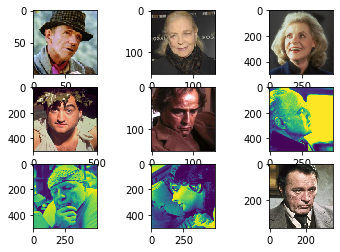

In [16]:
from matplotlib import pyplot
from matplotlib.image import imread
  
f, axarr = plt.subplots(3,3)
count=0
for i in range(3):
    for j in range(3):
        filename=valid_df.values[count][0]
        image=imread(filename)
        axarr[i,j].imshow(image)
        print(i,j,"Gender:",valid_df.values[count][1],"Age:",valid_df.values[count][2])
        count+=10

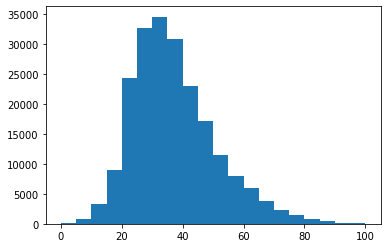

bin_start bin_end count cumulative_count
0.0 5.0 128.0 128.0
5.0 10.0 841.0 969.0
10.0 15.0 3274.0 4243.0
15.0 20.0 8924.0 13167.0
20.0 25.0 24363.0 37530.0
25.0 30.0 32595.0 70125.0
30.0 35.0 34494.0 104619.0
35.0 40.0 30775.0 135394.0
40.0 45.0 22941.0 158335.0
45.0 50.0 17174.0 175509.0
50.0 55.0 11444.0 186953.0
55.0 60.0 8010.0 194963.0
60.0 65.0 5881.0 200844.0
65.0 70.0 3825.0 204669.0
70.0 75.0 2374.0 207043.0
75.0 80.0 1529.0 208572.0
80.0 85.0 816.0 209388.0
85.0 90.0 384.0 209772.0
90.0 95.0 164.0 209936.0
95.0 100.0 54.0 209990.0


In [17]:
(n, bins, patches)=plt.hist(x=valid_df.age,bins=20);
plt.show();
total_count=0
print('bin_start','bin_end','count','cumulative_count')
for bin, count in zip(bins,n):
    total_count+=count
    print(bin,bin+5,count,total_count)

In [18]:
valid_df.gender.value_counts()
# Note: 0 for female and 1 for male
# There are more valid images of males than females. 

1    122327
0     87663
Name: gender, dtype: int64

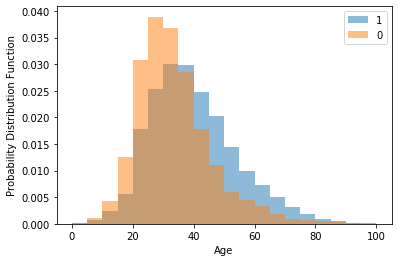

In [19]:
categories = valid_df['gender'].unique()

for c in categories:
    plt.hist(valid_df[valid_df['gender'] == c]['age'], alpha=0.5, label=c, bins=20, density=True)
plt.legend()
plt.ylabel('Probability Distribution Function')
plt.xlabel('Age')
plt.show()

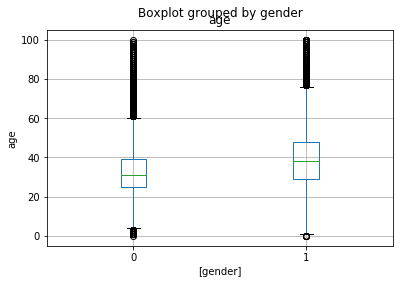

In [20]:
valid_df[['age', 'gender']].boxplot(by='gender')
plt.ylabel('age')
plt.show()

In [ ]:
from tqdm import tqdm
import cv2
from skimage import io

images = []
ages = []
genders = []
#img_dim=64
img_dim=32

total_count=valid_df.shape[0]

for i in tqdm(range(total_count)):
    impath=valid_df.values[i][0]
    image = io.imread(impath)
    image = cv2.resize(image, (img_dim,img_dim)) 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    images.append(image) #Check image format 
    genders.append(valid_df.values[i][1])
    ages.append(valid_df.values[i][2])

 23%|██▎       | 48052/209990 [44:35<2:25:10, 18.59it/s]

In [ ]:
all_images = np.squeeze(images) 
print(all_images.shape)

In [ ]:
#Normaliza image data
all_images = all_images.astype('float32')
all_images /= 255.

In [ ]:
gender_and_age=valid_df.drop('full_path', axis=1)
print(gender_and_age.head())

In [ ]:
# split dataset into 80% train and 20% test data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(all_images, gender_and_age,test_size=0.2,random_state=42,shuffle=True)
print('Peek at the training dataset')
print("Samples in Training:",x_train.shape[0])
print(y_train.info())

print('Peek at the testing dataset')
print("Samples in Testing:",x_test.shape[0])
print(y_test.info())
print(y_test.size)
print(y_test.age.values)

In [ ]:
#0 for female, 1 for male
train_test = {'male': [y_train['gender'].value_counts()[1], y_test['gender'].value_counts()[1]],
     'female': [y_train['gender'].value_counts()[0], y_test['gender'].value_counts()[0]]}
count_matrix = pd.DataFrame(train_test)
count_matrix = count_matrix.set_index(pd.Index(['train', 'test']))
count_matrix.plot(kind='bar', stacked=True, rot=0, figsize=(9, 6))
plt.ylabel('people')
plt.legend(loc=1)
plt.show()

In [ ]:
#scale age for better model performance

y_train.age = y_train.age/100
y_test.age = y_test.age/100


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras 
from keras.layers import *
from keras.models import *
from keras.callbacks import EarlyStopping
from keras import backend as K
from IPython.display import Image

In [ ]:
inputs = Input(shape = (32,32, 3))

    # Begin
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', strides= 2, activation='relu', input_shape=(32, 32, 3))(inputs)
model = MaxPool2D(pool_size=(3, 3), strides= 2)(model)
model = BatchNormalization(momentum=0.15)(model)

model = Conv2D(filters=64, kernel_size=(1, 1), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)

model = Conv2D(filters=64, kernel_size=(1, 1), padding='SAME', activation='relu')(model)
model = AveragePooling2D(pool_size=(2, 2), strides= 2)(model)
model = BatchNormalization(momentum=0.15)(model)

model = Conv2D(filters=128, kernel_size=(1, 1), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)

model = Conv2D(filters=128, kernel_size=(1, 1), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Conv2D(filters=256, kernel_size=(1, 1), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Conv2D(filters=256, kernel_size=(1, 1), padding='SAME', activation='relu')(model)

model = GlobalAveragePooling2D()(model)

age_model = Dense(1024, activation='relu')(model)
age_model= Dropout(0.4)(age_model)
age_model = Dense(1, activation='relu',name='age')(age_model)

gender_model = Dense(1024, activation='sigmoid')(model)
gender_model = Dropout(0.4)(gender_model)
gender_model = Dense(1, activation='sigmoid',name='gender')(gender_model)


In [ ]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = tf.keras.optimizers.Adam(0.00002), loss ={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae',"gender":"accuracy"})
model.summary()

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',restore_best_weights=True)]

BATCH_SIZE=128

#steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
#validation_steps = TotalvalidationSamples / ValidationBatchSize

history = model.fit(x_train,[y_train.age.values,y_train.gender.values],
                    validation_data=(x_test,[y_test.age.values,y_test.gender.values]),epochs = 25, 
                    steps_per_epoch=x_train.shape[0]//BATCH_SIZE ,shuffle = True,
                    validation_steps=x_test.shape[0]//BATCH_SIZE,callbacks=callbacks)

In [ ]:
model.save('age_gender_model_ipy.h5')
print(history.history.keys())

In [ ]:
plt.plot(history.history['age_loss'])
plt.plot(history.history['val_age_loss'])
plt.title('age model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['age_mae'])
plt.plot(history.history['val_age_mae'])
plt.title('age model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['gender_loss'])
plt.plot(history.history['val_gender_loss'])
plt.title('gender model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('gender model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()